# 참고 사이트
- 멋진 단어사전 만들기 me2.kr/tt6h9
- 멋진 단어사전 만들기 me2.kr/xle80
- 센텐스피스(SentencePiece) me2.kr/d2w43
- 자연어처리 한번에 끝내기 me2.kr/wpxil
- 모두의 딥러닝(책이름)

# 모델학습하기

## 기본 다운로드 및 파일 불러오기

In [129]:
# SentencePiece 설치
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
# konlpy 다운로드(Mecab 포함)
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-03 00:16:02--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-03 00:16:03--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc059d60d88c3ba0d971896d19aa.dl.dropboxusercontent.com/cd/0/get/BuFoBEbeNu1E_Iikkv7_5wNDqRcmtLBGoDEUg7ZSyHVaa1xw8nTl5z6VDo4xW7x7ooS7jocSzzJappqg2AvztStlPVbeM9si_UEzfStPifGkKw2BOYqlFApncte27478gleckuIM0D9N9Bs92_cwwkmmihNvb0ZOheDwwmjN7twLqENRdglhqZ5l1qE0CHa7Wt8/file?dl=1# [following]
--2022-10-03 00:16:04--  https://uc059d60d88c3ba0d971896d19aa.dl.dropboxusercontent.com/cd/0/get/BuFoBEbeNu1

In [131]:
# # 네이버 영화리뷰 감정 분석 문제
# cd로 풀고 싶은 위치로 이동
# %cd /content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict

# !git clone https://github.com/e9t/nsmc.git

In [132]:
import csv
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sentencepiece as spm
import konlpy

import tensorflow as tf

## 데이터 확인 및 전처리 하기

In [133]:
naver_train_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/nsmc/ratings_train.txt')
naver_test_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/nsmc/ratings_test.txt')

print('train_document 개수:', len(naver_train_df['document']))
display(naver_train_df.head())
print('\n, \n')
print('test_document 개수:',len(naver_test_df['document']))
display(naver_test_df.head())

train_document 개수: 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1



, 

test_document 개수: 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터를 합치기로 했다.
 왜냐하면 train과 test 파일이 개수만 빼고 동일하기 때문이다. 또한 전처리 등으로 해야할 작업이 똑같아서 시간낭비, 효율 낭비가 심하다. 또한 데이터를 통합해도 나중에 분리할 수있다.

In [134]:
naver_data = pd.concat([naver_train_df, naver_test_df])
len(naver_data['document'])

200000

### NULL, 중복 제거

### NULL 값 제거

In [135]:
naver_data.drop(['id'], axis=1, inplace=True) # column 중 id는 필요없어서 제거
naver_data = naver_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(naver_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [136]:
print('naver_data 개수', len(naver_data['document']))

naver_data 개수 199992


### 중복값 제거

In [137]:
count = 0
for idx,i in enumerate(naver_data.duplicated(['document'])):
    if i == True:
        count += 1
print('naver_data의 document 중복값', count)

naver_data의 document 중복값 5449


In [138]:
count = 0
for i in naver_data.drop_duplicates(['document', 'label']):
    if i == True:
            count += 1

print('naver_data의 document, label 중복값', count)

naver_data의 document, label 중복값 0


- 아래에 document, label 둘 다 같으면 삭제하도록했다.
- 예)


|document|label|
|---|---|
|a|0
|a|1
|a|1
위의 1번 표에서   

---- 

|document|label|
|---|---|
|a|0
|a|1

위의 2번 표가 된다.

가 된다. 하지만 아무런 중복 값이 다른 것을 보니
아마도 2번표 처럼 같은 값이라도 document라도 label이 다른듯 하다. 사람마다 생각하는게 다르므로 일단 넘어가기로 했다.

### 전처리 시각화

- label의 0과 1 비율 보기


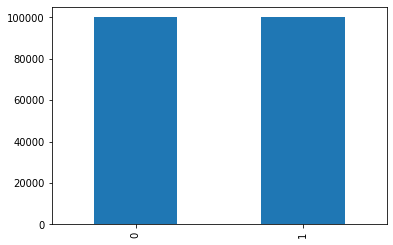

In [139]:
naver_data['label'].value_counts().plot(kind='bar');

- 문장의 최대, 최소, 평균 길이 보기

In [140]:
naver_document = naver_data['document']
naver_label = naver_data['label']

print('문장의 최대 길이: {}'.format(max(len(i) for i in naver_document)))
print('문장의 최초 길이: {}'.format(min(len(i) for i in naver_document)))
print('문장의 평균 길이: {}'.format((sum(map(len,naver_document)))//len(naver_document)))

문장의 최대 길이: 146
문장의 최초 길이: 1
문장의 평균 길이: 35


- 문장의 글자 개수에 따른 분포 보기

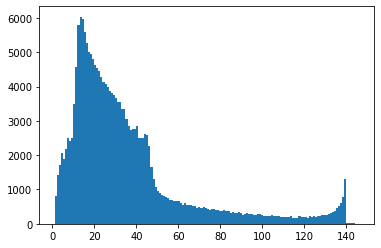

In [176]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in naver_document], bins=146)
plt.show()

- 문장의 글자 개수에 따른 문장 보기

In [141]:
print([s for s in naver_document if len(s) == 4])

['재밋는뎅', '킬링타임', '별로다.', '볼만해;', '연기 굿', '좋은영화', '굿 좋아', '재밌는데', '와...', '펑점조절', '싸우자!', '최고!!', '패륜영화', '어휴..', '재밌다.', '괜히봤다', '재미없음', '지루하다', '재미없다', '장난치냐', 'OOO기', '몰떡몰떡', 'good', '이건뭥미', '잼슴ㅇㅎ', '죽을래?', '짠하네요', '기대된디', '보고싶다', '나도별로', '추억돋네', '재밌어요', '야동!!', '왜봣지?', '볼만했음', '별로다.', '별로;;', '평점조절', '심하네.', 'good', '별로네요', '재밌어요', '재미없다', '돈아깝다', '별10개', '최고다.', '어이없다', '별루 .', '굿입니당', '와...', '옥빈님짱', 'good', '언제꺼임', '-_-^', '뭐냐이게', '개쩔었다', '그지같다', '안무섭다', '푹 잤음', '재밌네요', '괜찬았음', '안과 겉', '참쩔어요', '재 밌다', '별론데?', '괜찬군요', '최고지~', '걍 평작', '명작이다', '재밋구만', '공블리짱', '잼나ㅎㅎ', '""""', '재미없음', '으하하하', '재밌네요', '킬링타임', '그만하자', '별로..', '...굿', '이건멍미', '재밌다!', '보영누나', '달달..', '재밌네요', 'good', '허술하다', '넘잼있음', '재미있다', 'good', '좋았어요', '재밋어여', '씹쓰레기', '선동영화', '별로 ㅋ', '레전드.', '애절하다', '이연걸~', '재미없엉', '최고!!', '재미있음', '넘 잼따', '적절하다', '쩝...', '안습..', '지루력!', '재밌어요', '최고였다', '훈훈하다', '뭘봐!!', '어이없다', '재미있다', '재미없음', '재밌던데', '쒸레기~', '최고이지', '의리다.', '쓰렉이얌', '뽜야 뽜', '재밋는데', '구리네요', '그닥..', '최고!!', '의지부족', '좀지루함',

## SentencePiece 사용하기 

In [142]:
%cd /content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_document))

/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict


In [143]:
# Unigram 타입
spm.SentencePieceTrainer.Train(
    '--input=naver_review.txt --model_prefix=naver_Unigram --vocab_size=8000 --max_sentence_length=100')

In [144]:
# BPE 타입
spm.SentencePieceTrainer.Train(
    '--input=naver_review.txt --model_prefix=naver_BPE --vocab_size=8000 --model_type=bpe --max_sentence_length=100')

In [145]:
vocab_list_Unigram = pd.read_csv('naver_Unigram.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)

print('Unigram타입의 단어 개수:',len(vocab_list_Unigram))
display(vocab_list_Unigram[100:110])

Unigram타입의 단어 개수: 8000


,0,1
100,▁봤는데,-6.85408
101,미,-6.86086
102,▁없는,-6.86160
103,▁참,-6.86687
104,냐,-6.86744
105,^^,-6.86950
106,임,-6.87881
107,지만,-6.88062
108,▁한,-6.89561
109,드,-6.90539


In [146]:
vocab_list_BPE = pd.read_csv('naver_BPE.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)

print('BPE타입의 단어 개수:',len(vocab_list_BPE))
display(vocab_list_BPE[100:110])

BPE타입의 단어 개수: 8000


,0,1
100,▁완,-97
101,▁소,-98
102,었다,-99
103,▁생각,-100
104,▁못,-101
105,▁알,-102
106,▁뭐,-103
107,▁쓰레기,-104
108,^^,-105
109,;;,-106


In [147]:
# Unigram 타입
s_uni = spm.SentencePieceProcessor()
vocab_uni_file = "/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/naver_Unigram.model"
s_uni.load(vocab_uni_file)

sentence = [
  "아 더빙.. 진짜 짜증나네요 목소리	",
  "사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...",
]

for sen in sentence:
  print("문장", sen)
  print("문장을 pices로 => ", s_uni.encode_as_pieces(sen))
  print("문장을 id로 => ",s_uni.encode_as_ids(sen))
  print()

문장 아 더빙.. 진짜 짜증나네요 목소리	
문장을 pices로 =>  ['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
문장을 id로 =>  [46, 887, 5, 28, 1608, 65, 1781]

문장 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
문장을 pices로 =>  ['▁사이', '몬', '페', '그', '의', '▁', '익', '살', '스런', '▁연기가', '▁돋', '보', '였던', '▁영화', '!', '스파이더맨', '에서', '▁늙어', '보이', '기만', '▁했던', '▁커', '스틴', '▁', '...']
문장을 id로 =>  [3088, 2641, 1549, 230, 9, 3, 1431, 415, 2686, 530, 2249, 123, 2292, 6, 19, 6695, 58, 6843, 2500, 1403, 3371, 1932, 5499, 3, 7]



In [148]:
# BPE 타입
s_BPE = spm.SentencePieceProcessor()
vocab_BPE_file = "/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/naver_BPE.model"
s_BPE.load(vocab_BPE_file)

sentence = [
  "아 더빙.. 진짜 짜증나네요 목소리	",
  "사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...",
]

for sen in sentence:
  print("문장", sen)
  print("문장을 pices로 => ", s_uni.encode_as_pieces(sen))
  print("문장을 id로 => ",s_uni.encode_as_ids(sen))
  print()

문장 아 더빙.. 진짜 짜증나네요 목소리	
문장을 pices로 =>  ['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
문장을 id로 =>  [46, 887, 5, 28, 1608, 65, 1781]

문장 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
문장을 pices로 =>  ['▁사이', '몬', '페', '그', '의', '▁', '익', '살', '스런', '▁연기가', '▁돋', '보', '였던', '▁영화', '!', '스파이더맨', '에서', '▁늙어', '보이', '기만', '▁했던', '▁커', '스틴', '▁', '...']
문장을 id로 =>  [3088, 2641, 1549, 230, 9, 3, 1431, 415, 2686, 530, 2249, 123, 2292, 6, 19, 6695, 58, 6843, 2500, 1403, 3371, 1932, 5499, 3, 7]



### sp_tokenize() 메소드 구현하기

In [149]:
# Unigram 타입

def sp_unigram_tokenize(s_uni, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))
    path = "/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/naver_Unigram.vocab"
    with open(path, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [150]:
# Unigram 타입
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...', '이것은 제가 임의로 넣은 문자입니다.']
tensor_uni, word_index_uni, index_word_uni = sp_unigram_tokenize(s_uni, my_corpus)
print(tensor_uni)

[[ 438 3071   15 1053 2702    4    0    0    0    0    0    0    0]
 [1590 2233  202  613   10  270 7908  859    7    0    0    0    0]
 [1789   18 1908 2668    9   31    3 2675   18 1693   52  243    4]]


In [151]:
tensor_uni, word_index_uni, index_word_uni = sp_unigram_tokenize(s_uni, naver_document)

print(tensor_uni.shape)

(199992, 133)


In [152]:
# BPE  타입

def sp_bpe_tokenize(s_BPE, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))
    path = "/content/drive/MyDrive/Colab Notebooks/아이펠/02NLP_word_dict/naver_BPE.vocab"
    with open(path, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [153]:
# BPE  타입
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...', '이것은 제가 임의로 넣은 문자입니다.']
tensor_bpe, word_index_bpe, index_word_bpe = sp_bpe_tokenize(s_BPE, my_corpus)
print(tensor_bpe)
print(tensor_bpe.shape)

[[ 438 3071   15 1053 2702    4    0    0    0    0    0    0    0]
 [1590 2233  202  613   10  270 7908  859    7    0    0    0    0]
 [1789   18 1908 2668    9   31    3 2675   18 1693   52  243    4]]
(3, 13)


In [154]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_bpe_tokenize(s_BPE, naver_document)

print(tensor_bpe.shape)

(199992, 133)


### 모델 학습하기

In [155]:
# 데이터 분할
X_train = tensor_uni[:146182]
X_test = tensor_uni[146182:]

y_train = np.array(list(naver_label[:146182]))
y_test = np.array(list(naver_label[146182:]))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 133)
(96182,)
(96182, 133)
(96182,)


In [156]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_5 (LSTM)               (None, 12)                1392      
                                                                 
 dense_10 (Dense)            (None, 8)                 104       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [157]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 7s 19ms/step - loss: 0.6931 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 2/20
188/188 [==============================] - 3s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 3/20
188/188 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 4/20
188/188 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 5/20
188/188 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 6/20
188/188 [==============================] - 2s 13ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 7/20
188/188 [==============================] - 2s 13ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5004

1682/1682 - 8s - loss: 0.6932 - accuracy: 0.4968 - 8s/epoch - 5ms/step
[0.693181574344635, 0.4967849850654602]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


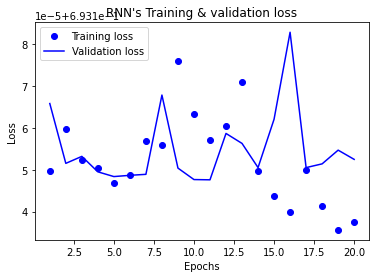

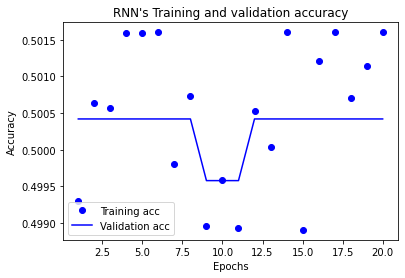

In [158]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [159]:
# 데이터 분할
X_train = tensor_bpe[:146182]
X_test = tensor_bpe[146182:]

y_train = np.array(list(naver_label[:146182]))
y_test = np.array(list(naver_label[146182:]))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 133)
(96182,)


In [160]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_6 (LSTM)               (None, 12)                1392      
                                                                 
 dense_12 (Dense)            (None, 8)                 104       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [161]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 6s 18ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 2/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.4996
Epoch 3/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 4/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 5/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 6/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 7/20
188/188 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5004

1682/1682 - 8s - loss: 0.6932 - accuracy: 0.4968 - 8s/epoch - 5ms/step
[0.6931604743003845, 0.4967849850654602]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


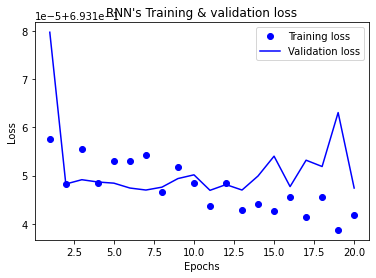

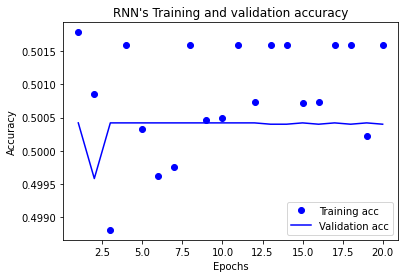

In [162]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기



In [163]:
from konlpy.tag import Kkma,Hannanum, Komoran, Okt, Mecab
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [164]:
tokenizer = Mecab()


stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(naver_train_df, naver_test_df, num_words=10000):
    naver_train_df.drop_duplicates(subset=['document'], inplace=True)
    naver_train_df = naver_train_df.dropna(how = 'any') 
    naver_test_df.drop_duplicates(subset=['document'], inplace=True)
    naver_test_df = naver_test_df.dropna(how = 'any') 

    X_train = []
    for sentence in naver_train_df['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in naver_test_df['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(naver_train_df['label'])), X_test, np.array(list(naver_test_df['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(naver_train_df, naver_test_df)

In [165]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [166]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [167]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [168]:
# 데이터셋 내 문장 길이 분포 파악
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))


[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [169]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [170]:
# 적절한 최대 문장 길이를 지정
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [171]:
# 패딩 작업
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)


(146182, 41)


In [172]:
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [173]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_7 (LSTM)               (None, 12)                1392      
                                                                 
 dense_14 (Dense)            (None, 8)                 104       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [174]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/20
188/188 [==============================] - 5s 14ms/step - loss: 0.5688 - accuracy: 0.7264 - val_loss: 0.4219 - val_accuracy: 0.8312
Epoch 2/20
188/188 [==============================] - 2s 12ms/step - loss: 0.3623 - accuracy: 0.8480 - val_loss: 0.3531 - val_accuracy: 0.8482
Epoch 3/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3230 - accuracy: 0.8665 - val_loss: 0.3476 - val_accuracy: 0.8495
Epoch 4/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3032 - accuracy: 0.8756 - val_loss: 0.3495 - val_accuracy: 0.8492
Epoch 5/20
188/188 [==============================] - 2s 11ms/step - loss: 0.2899 - accuracy: 0.8815 - val_loss: 0.3550 - val_accuracy: 0.8475
Epoch 6/20
188/188 [==============================] - 2s 12ms/step - loss: 0.2765 - accuracy: 0.8885 - val_loss: 0.3537 - val_accuracy: 0.8491
Epoch 7/20
188/188 [==============================] - 2s 11ms/step - loss: 0.2644 - accuracy: 0.8946 - val_loss: 0.3644 - val_accuracy: 0.8453

1537/1537 - 4s - loss: 0.5438 - accuracy: 0.8292 - 4s/epoch - 3ms/step
[0.5438194870948792, 0.8292409777641296]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


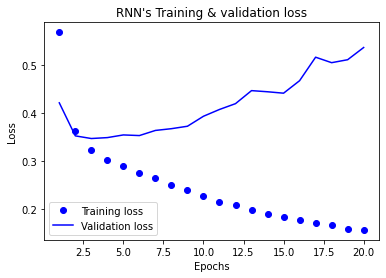

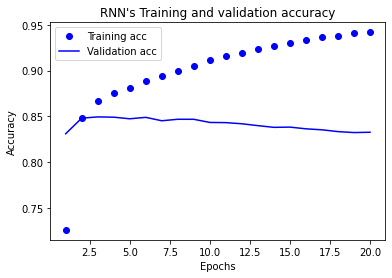

In [175]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

- 처음부터터 끝까지지 역경과과 도전이었고 괴로웠다.
1. 단어를 토큰화한다.
2. 토큰으로 학습(fit)을 한다.
3. 결과를 시각화한다.  

이렇게 3가지 과정 밖에 없지만 괴로웠다. 어떻게 토큰으로 학습을 한다는게 뭔지 몰라서 힘들었다.
- NLP 이전에는 pandas에서 필요한 컬럼을 추출해서 X_train, y_train에 할당하고 학습을 했다. 하지만 이제는 문장을 단어로 쪼개고 학습을 해야한다.
- SentencePiece는 2주일 중 일주일 반을 써서 어찌어찌 이해하고 나름대로 코드도 넣어보고 했다. 하지만 konlpy은 시간이 부족해서 코드를 대략적인 이해만 가능했고, 결국 베껴쓰기를 해버렸다.  

- 문장 2~3줄 넣은 후 학습까지 하는 체험을 했지만, 대규모 문장(파일)을 어떻게 처리해야하는지 몰라서 계속 실패와 좌절이 있었다.
- SentencePiece는 그 자체로 어떻게 쓰는지 몰라서 해맸다. 어찌저찌해서 .model, .vocab을 만들었는데, 각각 어디에 쓰느지도 몰랐다. .model은 검색을 해도 여는 방법이 없었고, vocab은 판다스로 보니 단어장 형태가 되어있었다. 검색을 해도 대부분 학습은 나오지 않았다. 이걸로 어떻게 학습을 해야할지, 학습한다고 해도 label(taget)과 함께 학습해야 할지 몰라서 혼란스러웠다.
- SentencePiece를 토큰화하고 학습까지 따라했는데 acc가 50에서 고정이 되어서 방법을 찾으려했으나 시간이 부족해서 도중에 그만두었다.
- konlpy를 import하고 mecab,kkma,hannanum 등을 쓰면 형태소 단위로 쪼개지는 걸 알았다. 하지만 이걸 어떻게 학습하는지 몰랐다.  행태소 쪼깨기까지는 문제 없었다. 하지만 어떻게 토큰화(탠서)를 하는지 몰랐다. SentencePiece와 마찬가지로 어떻게 학습할 지도 몰랐다.  


## 아쉬운 점


### 처음에는 여러가지  실험을 하고 싶었다.


- kpnlpy의 kkma, okt, hannanum, mecab등을 사용해보기
- 트리맵, 워드 클라우드 만들기

- #### SentencePiec로 만든 단어장으로 문장 뭉치를 가져와서 실험해보긱

- 아래의 그림을 근거로 문장의 길이가 4~45, 60~130, 130~146을 토큰화 하고 학습 ⇒ 정확도 등의 데이터 확인 및 분석

![image](https://res.craft.do/user/full/1dd87f5a-9b2d-2555-175a-a81192662092/doc/44E6E4F5-7710-43BF-9461-AEB47612939D/5FABA534-4A60-4A7E-B700-C062FC905949_2/ol2hzXiUf083YgM5xqy9IkoGqNSClLASlrSkeYkpzu4z/%202022-10-03%2009.43.44.png)

등등 여러가지 아이디어가 떠올랐지만 토큰화에서부터 너무 많은 시간을 써서 못한게 아쉬웟다.
